In [1]:
# Import libraries
import numpy as np
import math
import random
import pandas as pd
import csv

import scipy.stats as stats
from statsmodels.stats.multitest import multipletests

import statsmodels.api as sm # linear regression

import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt

import os

# Directory path
myDir = "/Users/junjie/Desktop/OneDrive - The University of Chicago (1)/Python"
os.chdir(myDir)
import ProxseqClasses as PC

#*****
mpl.rcdefaults()
# Set font to be arial
mpl.rc('font', **{'sans-serif':'Arial', 'size':12})
mpl.rcParams['mathtext.rm'] = 'sans' # to have non-italic greek letter, use r'$\mathrm{\alpha}$', does NOT work with f-string
mpl.rcParams['axes.titlesize'] = 12
# Set default tick size
mpl.rcParams['xtick.major.size'] = 5.5
mpl.rcParams['ytick.major.size'] = 5.5
mpl.rcParams['xtick.minor.size'] = 2.5
mpl.rcParams['ytick.minor.size'] = 2.5
# Default legend settings
mpl.rcParams['legend.fancybox'] = False
mpl.rcParams['legend.edgecolor'] = 'k'

#to store text as text, not as path
new_rc_params = {'text.usetex': False,
                 "svg.fonttype": 'none'}
mpl.rcParams.update(new_rc_params)
#*****
# Seed number
np.random.seed(2019)
random.seed(2019)

In [2]:
save_dir = "/Users/junjie/Desktop/OneDrive - The University of Chicago (1)/Experimental data/Glycan_proxseq/manuscript/figures_svg/"

In [3]:
#raw count data
data = pd.read_csv('/Users/junjie/Desktop/OneDrive - The University of Chicago (1)/Python/GPS/20240828/0828_jr_count.txt.gz',sep="\t",index_col=0)

In [4]:
all_protein_list = ['CD3', 'CD4',  'CD28',  'CD2', 'CD147', 'CD81', 'CD9', 'CD21', 'ICAM1', 'PDL1', 'HLADR', 
                'CD80', 'CD19', 'CD86', 'IgG1', 'IgG2a', 'IgG2b', 'free_oligo']

all_lectin_list = ['PHA-L', 'ConA', 'PNA', 'MAL-I', 'MAL-II', 'SNA', 'DBA', 'ECA', 'AAL', 'DSL', 'LEL', 'free_oligo']

In [5]:
index_list = []
for protein in all_protein_list:
    for lectin in all_lectin_list:
        index_list.append(f'{protein}:{lectin}')
selected_rows = []  
for index in index_list:
    if index in data.index:
        selected_rows.append(data.loc[index])
# Create a new DataFrame from the selected rows
target = pd.DataFrame(selected_rows)
target = target.loc[~target.index.str.contains('free_oligo:free_oligo'),:]

In [6]:
raji = target.loc[:,target.columns.str.contains('raji')]
jurkat = target.loc[:,target.columns.str.contains('jurkat')]

In [7]:
#filter droplet or doublet 
#for jurkat, filter cells have total counts less than 50 or more than 20000
#for raji, filter cells have total counts less than 50 or more than 60000
jurkat = jurkat.loc[:,(jurkat.sum(axis=0)>50)&(jurkat.sum(axis=0)<20000)]
raji = raji.loc[:,(raji.sum(axis=0)>50)&(raji.sum(axis=0)<60000)]

In [8]:
#filter_list based on clustering

# List of CSV file paths
jurkat_csv_files = ['/Users/junjie/Desktop/OneDrive - The University of Chicago (1)/Python/GPS/20240828/protein_mismatch_cluster_jurkat.csv',
            '/Users/junjie/Desktop/OneDrive - The University of Chicago (1)/Python/GPS/20240828/lectin_mismatch_cluster_jurkat.csv',
            '/Users/junjie/Desktop/OneDrive - The University of Chicago (1)/Python/GPS/20240828/pl_mismatch_cluster_jurkat.csv']
raji_csv_files = ['/Users/junjie/Desktop/OneDrive - The University of Chicago (1)/Python/GPS/20240828/protein_mismatch_cluster_raji.csv',
                '/Users/junjie/Desktop/OneDrive - The University of Chicago (1)/Python/GPS/20240828/lectin_mismatch_cluster_raji.csv',
             '/Users/junjie/Desktop/OneDrive - The University of Chicago (1)/Python/GPS/20240828/pl_mismatch_cluster_raji.csv']

# Initialize an empty list to store the data
combined_list_jurkat = []
combined_list_raji = []

# Loop through each CSV file and append the data to the list
for file in jurkat_csv_files:
    with open(file, mode='r') as f:
        reader = csv.reader(f)
        # Append each row to the combined_list
        for row in reader:
            combined_list_jurkat.extend(row)

for file in raji_csv_files:
    with open(file, mode='r') as f:
        reader = csv.reader(f)
        # Append each row to the combined_list
        for row in reader:
            combined_list_raji.extend(row)

In [10]:
#background correction for jurkat
#(IgG1 + IgG2a + IgG2b)/3 as baseline, for certain lectin, compare all_antibody:lectin to baseline:lectin value 
# and perform subtraction
new_jurkat = jurkat[~jurkat.index.str.contains("IgG")].copy()

In [11]:
#background correction for raji 
new_raji = raji[~raji.index.str.contains("IgG")].copy()

In [12]:
pla_raji = PC.plaObject(new_raji.loc[:,~new_raji.columns.isin(combined_list_raji)])
#pla_raji = PC.plaObject(new_raji)
pla_raji.calculateProteinCount()
pla_jurkat = PC.plaObject(new_jurkat.loc[:,~new_jurkat.columns.isin(combined_list_jurkat)])
#pla_jurkat = PC.plaObject(new_jurkat)
pla_jurkat.calculateProteinCount()

my_protein = ['CD3', 'CD4', 'CD28', 'CD2', 'CD147', 'CD81', 'CD9', 'CD21', 'ICAM1', 'PDL1', 'HLADR', 
              'CD80', 'CD19', 'CD86']
protein_T = pla_jurkat.protein_count.loc[my_protein,:]
protein_B = pla_raji.protein_count.loc[my_protein,:]

my_lectin = ['PHA-L', 'ConA', 'PNA', 'MAL-I', 'MAL-II', 'SNA', 'DBA', 'ECA', 'AAL', 'DSL', 'LEL']
lectin_T = pla_jurkat.protein_count.loc[my_lectin,:]
lectin_B = pla_raji.protein_count.loc[my_lectin,:]

Text(0.5, 1.0, 'Pearson Correlation Coefficient')

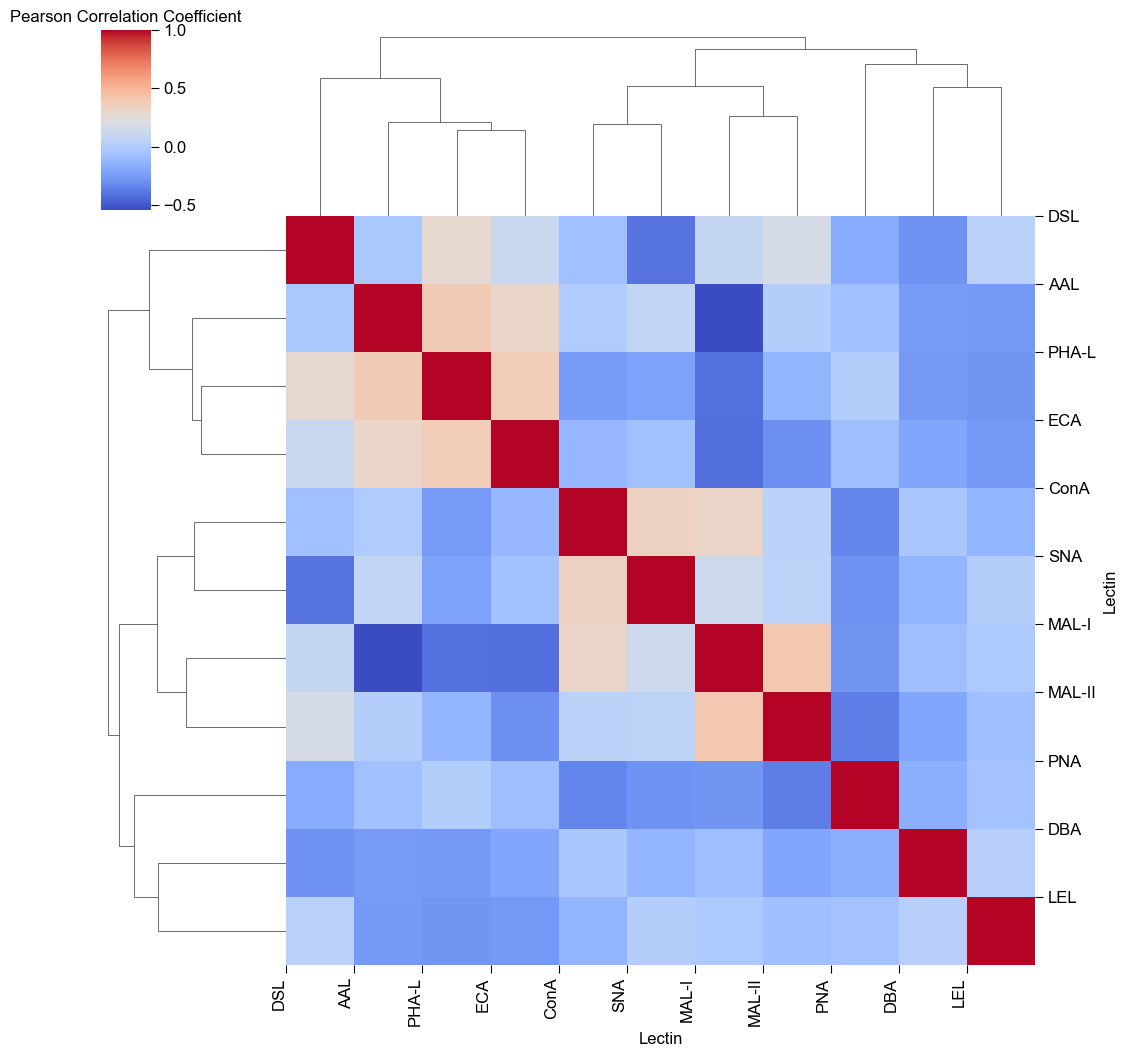

In [18]:
clustermap = sns.clustermap(clr_lectin_B.T.corr(), cmap='coolwarm')

# Get the order of rows and columns after clustering
row_order = clustermap.dendrogram_row.reordered_ind
col_order = clustermap.dendrogram_col.reordered_ind

# Customize x-tick and y-tick labels to follow the cluster order
clustermap.ax_heatmap.set_xticks(range(len(col_order)))
clustermap.ax_heatmap.set_yticks(range(len(row_order)))

# Set x-tick and y-tick labels based on the cluster order
clustermap.ax_heatmap.set_xticklabels(clr_lectin_B.index[col_order], rotation=90, ha='right')
clustermap.ax_heatmap.set_yticklabels(clr_lectin_B.index[row_order], rotation=0)

clustermap.ax_heatmap.set_xlabel('Lectin')
clustermap.ax_heatmap.set_ylabel('Lectin')
# Show the plot
plt.title('Pearson Correlation Coefficient')

In [12]:
# Define the CLR normalization function adapted from Seurat
def clr_function(column):
    # Filter out zeros for log transformation and only include positive values
    positive_values = column[column > 0]
    
    # Calculate the mean of log-transformed positive values
    mean_log = np.sum(np.log1p(positive_values)) / len(column)
    
    # Normalize by subtracting the exponential mean from each log-transformed value
    clr_values = np.log1p(column / np.exp(mean_log))
    
    return clr_values

# Apply CLR normalization to cells
clr_protein_T = protein_T.apply(clr_function,axis=0)
clr_protein_B = protein_B.apply(clr_function,axis=0)
clr_lectin_T = lectin_T.apply(clr_function,axis=0)
clr_lectin_B = lectin_B.apply(clr_function,axis=0)

In [ ]:
#protein after CLR normalization
#protein count 
temp1 = pd.DataFrame(0, index=clr_protein_T.columns, columns=clr_protein_T.index)
for i in temp1.columns:
    temp1.loc[:,i] = clr_protein_T.loc[i,:]

temp1.loc[:,"type"] = "Jurkat"
temp2 = pd.DataFrame(0, index=clr_protein_B.columns, columns=clr_protein_B.index)
for i in temp2.columns:
    temp2.loc[:,i] = clr_protein_B.loc[i,:]
temp2.loc[:,"type"] = "Raji"
temp = pd.concat((temp2, temp1), axis=0)

# Violin plot      
fig, ax = plt.subplots(nrows=4, ncols=4, figsize=(12, 12))  # Adjusted for 20 subplots
np.random.seed(1)

for counter, val in enumerate(my_protein):  # Updated to iterate over the provided protein list
    row = counter // 4  # Adjusted for 4 columns
    col = counter % 4
    sns.violinplot(y=val, x="type", data=temp, ax=ax[row, col],
                   cut=0, saturation=100, inner=None)
    sns.stripplot(y=val, x="type", data=temp, ax=ax[row, col],
                  jitter=0.25, color='k', size=3)
    ax[row, col].set_title(val)
    if row == 4:  # Adjusted the row index for labeling x-axis
        ax[row, col].set_xlabel("Cell type")
    else:
        ax[row, col].set_xlabel("")
    if col == 0:
        ax[row, col].set_ylabel("CLR Normalization Count")
    else:
        ax[row, col].set_ylabel("")
ax[3,2].axis("off")
ax[3,3].axis("off")
fig.tight_layout(w_pad=1.3, h_pad=1.3)  # Adjust layout spacing if needed
#sns.despine(fig=fig)

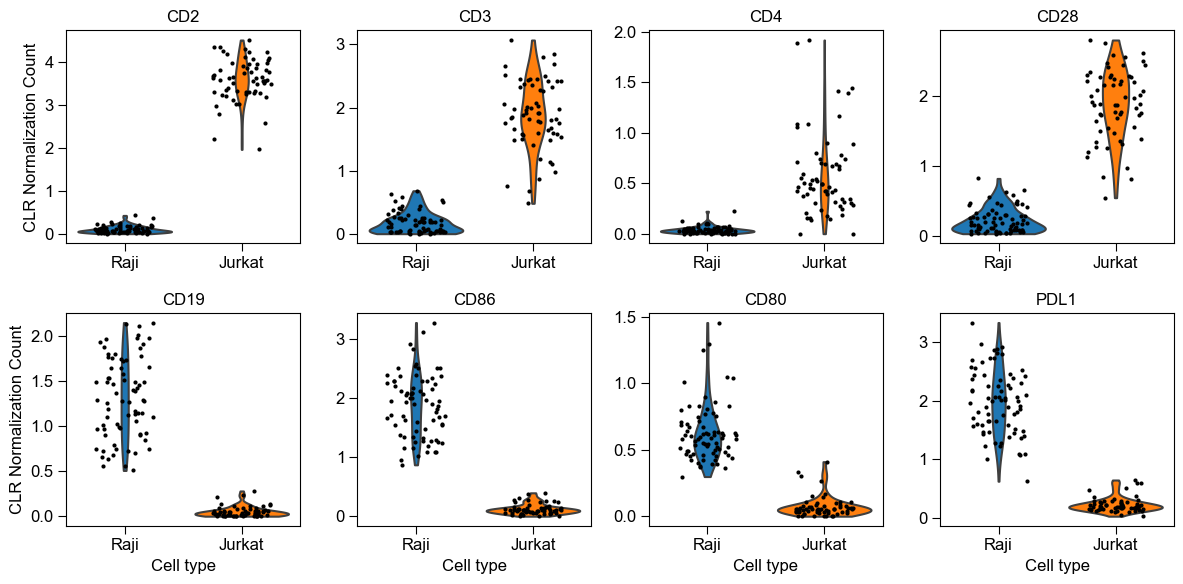

In [14]:
#show a smaller panel 
# Filter the protein list to include only the desired proteins
my_protein_6 = ['CD2', 'CD3', 'CD4', 'CD28', 'CD19', 'CD86', 'CD80', 'PDL1']

# Prepare the violin plot layout
fig, ax = plt.subplots(nrows=2, ncols=4, figsize=(12, 6))  # 2 rows, 4 columns for 8 proteins
np.random.seed(1)

# Iterate over the selected proteins and plot
for counter, val in enumerate(my_protein_6):
    row = counter // 4  # Determine the row index
    col = counter % 4  # Determine the column index
    sns.violinplot(
        y=val, x="type", data=temp, ax=ax[row, col],
        cut=0, saturation=1, inner=None, #palette="Set2"
    )
    sns.stripplot(
        y=val, x="type", data=temp, ax=ax[row, col],
        jitter=0.25, color='k', size=3
    )
    ax[row, col].set_title(val)
    if row == 1:  # Add x-axis label for the second row
        ax[row, col].set_xlabel("Cell type")
    else:
        ax[row, col].set_xlabel("")
    if col == 0:  # Add y-axis label for the first column
        ax[row, col].set_ylabel("CLR Normalization Count")
    else:
        ax[row, col].set_ylabel("")

# Adjust layout
fig.tight_layout(w_pad=1.3, h_pad=1.3)  # Adjust spacing
#sns.despine(fig=fig)  # Remove unnecessary spines
fig.savefig(save_dir+"Fig2_protein.svg",
            bbox_inches='tight', pad_inches=0)

In [ ]:
#show a smaller panel 
# Filter the protein list to include only the desired proteins
my_protein_si = ['CD147', 'CD81', 'CD9', 'CD21', 'ICAM1', 'HLADR']

# Prepare the violin plot layout
fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(9, 6))  # 2 rows, 3 columns for 6 proteins
np.random.seed(1)

# Iterate over the selected proteins and plot
for counter, val in enumerate(my_protein_si):
    row = counter // 3  # Determine the row index
    col = counter % 3  # Determine the column index
    sns.violinplot(
        y=val, x="type", data=temp, ax=ax[row, col],
        cut=0, saturation=1, inner=None, #palette="Set2"
    )
    sns.stripplot(
        y=val, x="type", data=temp, ax=ax[row, col],
        jitter=0.25, color='k', size=3
    )
    ax[row, col].set_title(val)
    if row == 1:  # Add x-axis label for the second row
        ax[row, col].set_xlabel("Cell type")
    else:
        ax[row, col].set_xlabel("")
    if col == 0:  # Add y-axis label for the first column
        ax[row, col].set_ylabel("CLR Normalization Count")
    else:
        ax[row, col].set_ylabel("")

# Adjust layout
fig.tight_layout(w_pad=1.3, h_pad=1.3)  # Adjust spacing
#sns.despine(fig=fig)  # Remove unnecessary spines
fig.savefig(save_dir+"SI_jr_protein.svg",
            bbox_inches='tight', pad_inches=0.5)

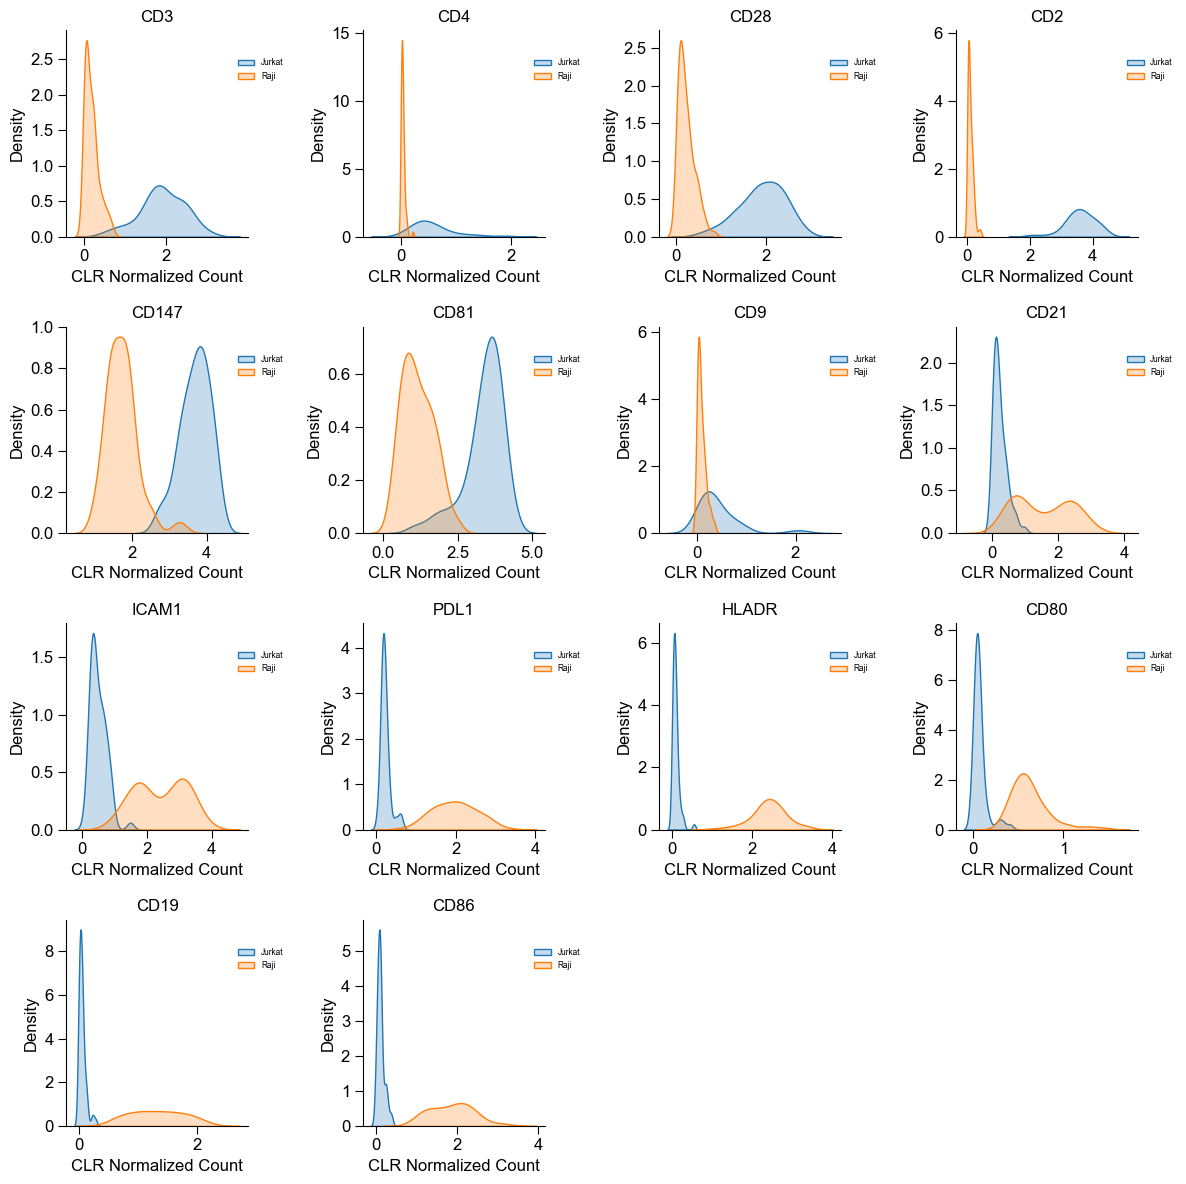

In [13]:
#use kde plot instead
#kde plot for protein
temp1 = pd.DataFrame(0, index=clr_protein_T.columns, columns=clr_protein_T.index)
for i in temp1.columns:
    temp1.loc[:,i] = clr_protein_T.loc[i,:]
temp1.loc[:,"type"] = "Jurkat"

temp2 = pd.DataFrame(0, index=clr_protein_B.columns, columns=clr_protein_B.index)
for i in temp2.columns:
    temp2.loc[:,i] = clr_protein_B.loc[i,:]
temp2.loc[:,"type"] = "Raji"

# Combine data
temp = pd.concat((temp1, temp2), axis=0)
#temp.replace(0, 10, inplace=True) 

# Define consistent tick values for x and y axes
#x_ticks = [1, 10, 100, 1000, 10000, 100000]  # Assuming log scale, adjust these values as needed
#y_ticks = [0, 0.5, 1.0, 1.5, 2.0, 2.5, 3.0] 

# Creating KDE plot with stripplot overlay
fig, ax = plt.subplots(nrows=4, ncols=4, figsize=(12, 12)) 
np.random.seed(1)

for counter, val in enumerate(my_protein):
    row = counter // 4
    col = counter % 4
    sns.kdeplot(x=val, data=temp[temp['type']=='Jurkat'], fill=True, label='Jurkat', ax=ax[row,col])
    sns.kdeplot(x=val, data=temp[temp['type']=='Raji'], fill=True, label='Raji', ax=ax[row,col])
    ax[row, col].set_title(val)
    ax[row, col].set_xlabel('CLR Normalized Count')
    #ax[row, col].set_xticks(x_ticks)
    #ax[row, col].set_yticks(y_ticks)
    ax[row, col].legend(loc='upper left', bbox_to_anchor=(0.9,0.9),frameon=False, prop={'size': 6})
# Hide empty subplots

ax[3,2].axis("off")
ax[3,3].axis("off")

fig.tight_layout(w_pad=1.3, h_pad=1.3)  # Adjust layout spacing
sns.despine(fig=fig)

In [14]:
import scanpy as sc

adata_T = sc.AnnData(clr_protein_T.T)
adata_B = sc.AnnData(clr_protein_B.T)
adata_T.obs['Ground truth'] = 'Jurkat'
adata_B.obs['Ground truth'] = 'Raji'
adata_p = sc.concat([adata_T, adata_B])
adata_p.raw = adata_p # freeze the state in `.raw`
#zero mean and unit variance
sc.pp.scale(adata_p, max_value=10)
#PCA
sc.tl.pca(adata_p, svd_solver='arpack')

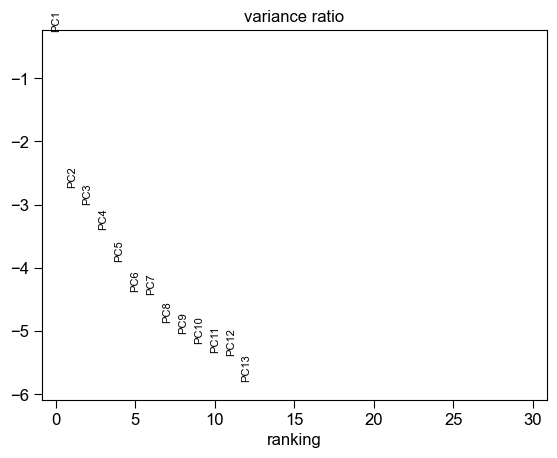

In [15]:
sc.pl.pca_variance_ratio(adata_p, log=True)

In [16]:
sc.pp.neighbors(adata_p, n_neighbors=10, n_pcs=6)
sc.tl.umap(adata_p)
sc.tl.leiden(adata_p,key_added='Unsupervised clusters',resolution=0.1)

/Users/junjie/anaconda3/envs/scanpy_Prox-seq/lib/python3.10/site-packages/scanpy/tools/_rank_genes_groups.py:420: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'logfoldchanges'] = np.log2(
/Users/junjie/anaconda3/envs/scanpy_Prox-seq/lib/python3.10/site-packages/scanpy/tools/_rank_genes_groups.py:420: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'logfoldchanges'] = np.log2(


{'heatmap_ax': <Axes: >,
 'groupby_ax': <Axes: xlabel='Unsupervised clusters'>,
 'gene_groups_ax': <Axes: >}

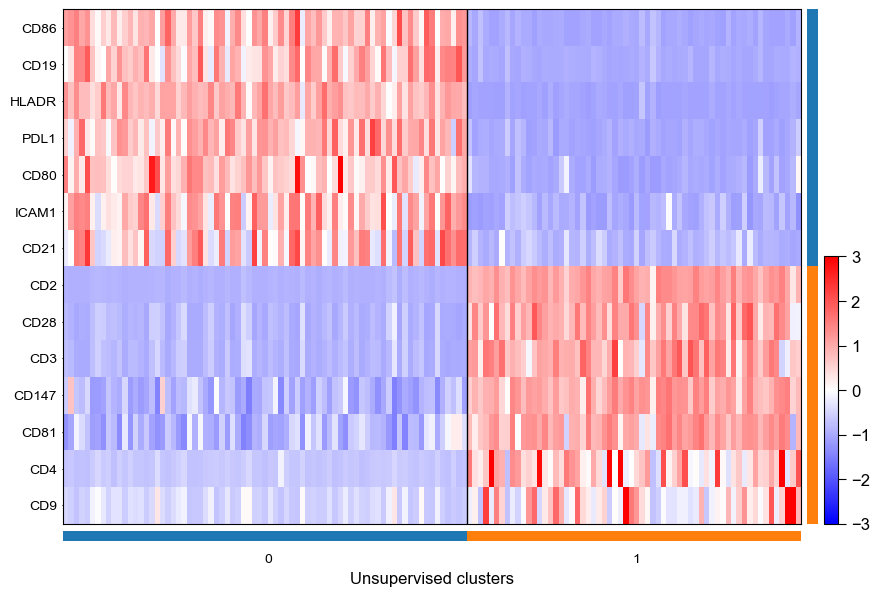

In [34]:
sc.tl.rank_genes_groups(adata_p, groupby='Unsupervised clusters', method='wilcoxon')
sc.tl.dendrogram(adata_p, groupby='Unsupervised clusters')
sc.pl.rank_genes_groups_heatmap(adata_p, n_genes=7,  swap_axes=True, vmin=-3, vmax=3, cmap='bwr',figsize=(10,7), show=False, dendrogram=False)

/Users/junjie/anaconda3/envs/scanpy_Prox-seq/lib/python3.10/site-packages/scanpy/tools/_rank_genes_groups.py:420: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'logfoldchanges'] = np.log2(
/Users/junjie/anaconda3/envs/scanpy_Prox-seq/lib/python3.10/site-packages/scanpy/tools/_rank_genes_groups.py:420: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'logfoldchanges'] = np.log2(


{'heatmap_ax': <Axes: >,
 'groupby_ax': <Axes: xlabel='Ground truth'>,
 'dendrogram_ax': <Axes: >,
 'gene_groups_ax': <Axes: >}

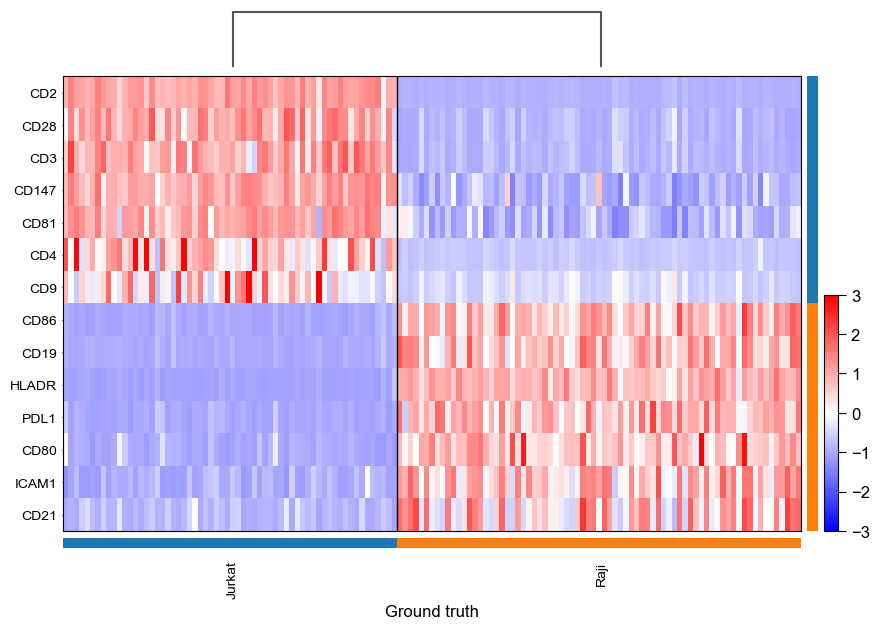

In [65]:
sc.tl.rank_genes_groups(adata_p, groupby='Ground truth', method='wilcoxon')
sc.tl.dendrogram(adata_p, groupby='Ground truth')
sc.pl.rank_genes_groups_heatmap(adata_p, n_genes=7,  swap_axes=True, vmin=-3, vmax=3, cmap='bwr',figsize=(10,7), show=False, dendrogram=True)

/Users/junjie/anaconda3/envs/scanpy_Prox-seq/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1217: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/Users/junjie/anaconda3/envs/scanpy_Prox-seq/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/Users/junjie/anaconda3/envs/scanpy_Prox-seq/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1217: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_

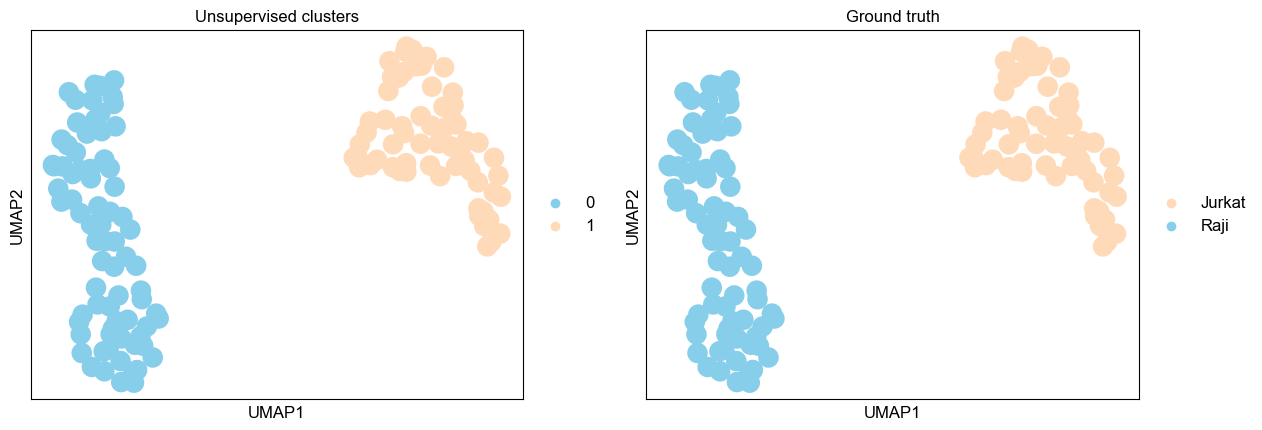

In [17]:
# Define custom color palettes
cluster_colors = {
    '0': 'skyblue',    # Example colors for clusters
    '1': 'peachpuff'
}

cell_type_colors = {
    'Raji': 'skyblue',
    'Jurkat': 'peachpuff'
}

adata_p.obs['Unsupervised clusters'] = adata_p.obs['Unsupervised clusters'].astype('category')
adata_p.obs['Ground truth'] = adata_p.obs['Ground truth'].astype('category')

# Assign custom color palettes to adata_p
adata_p.uns['Unsupervised clusters_colors'] = [cluster_colors[label] for label in adata_p.obs['Unsupervised clusters'].cat.categories]
adata_p.uns['Ground truth_colors'] = [cell_type_colors[label] for label in adata_p.obs['Ground truth'].cat.categories]

sc.pl.umap(adata_p,color=['Unsupervised clusters','Ground truth'])

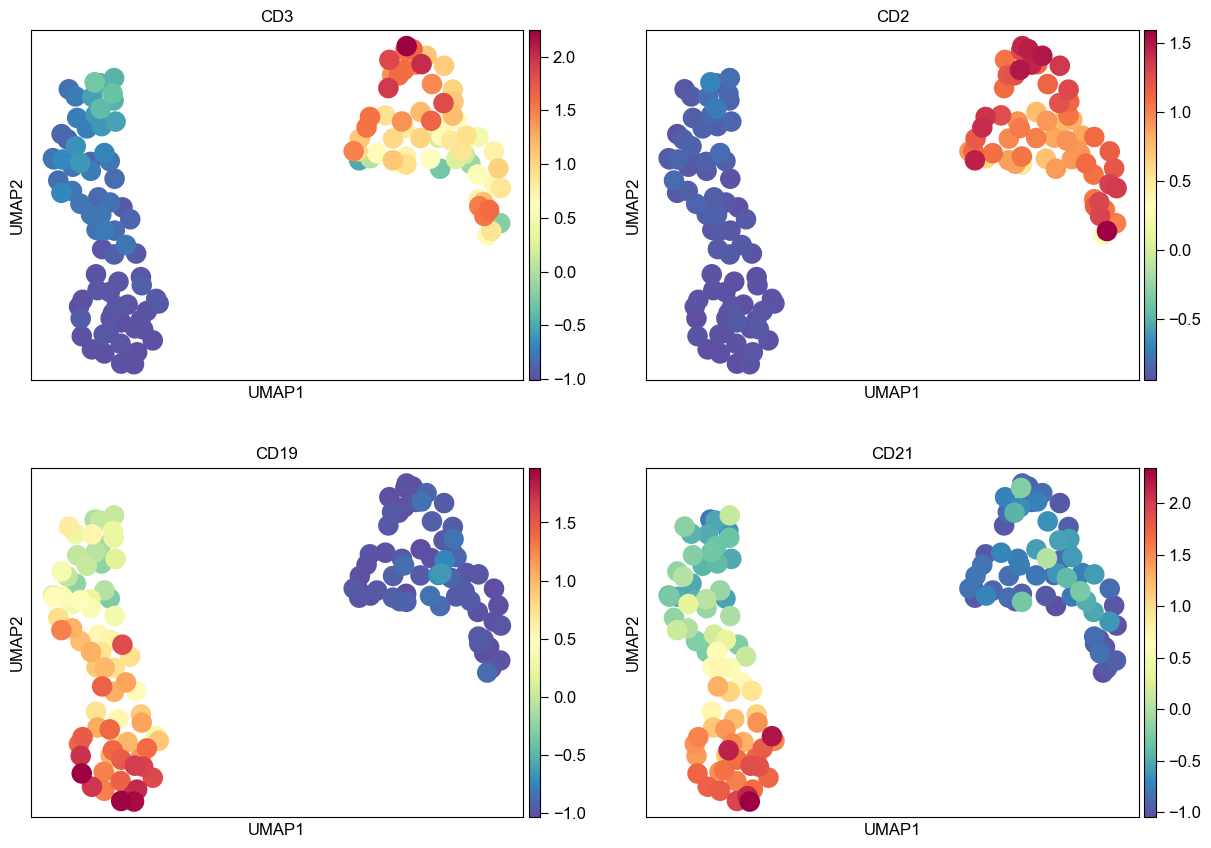

In [34]:
sc.pl.umap(adata_p,color=['CD3','CD2','CD19','CD21'], cmap='Spectral_r', ncols=2)

In [36]:
from sklearn.metrics import silhouette_score
silhouette_avg = silhouette_score(adata_p.X, adata_p.obs['clusters'])
print(silhouette_avg)

0.6356050351827863


In [66]:
from sklearn.metrics import adjusted_rand_score

ari_score = adjusted_rand_score(adata_p.obs['cell_type'], adata_p.obs['clusters'])
print(f'Adjusted Rand Index (ARI): {ari_score}')

Adjusted Rand Index (ARI): 1.0


In [67]:
from sklearn.metrics import normalized_mutual_info_score

nmi_score = normalized_mutual_info_score(adata_p.obs['cell_type'], adata_p.obs['clusters'])
print(f'Normalized Mutual Information (NMI): {nmi_score}')

Normalized Mutual Information (NMI): 1.0


Lectin

In [35]:
adata_T = sc.AnnData(clr_lectin_T.T)
adata_B = sc.AnnData(clr_lectin_B.T)
adata_T.obs['Ground truth'] = 'Jurkat'
adata_B.obs['Ground truth'] = 'Raji'
adata_l = sc.concat([adata_T, adata_B])
adata_l.raw = adata_l # freeze the state in `.raw`
#zero mean and unit variance
sc.pp.scale(adata_l, max_value=10)
#PCA
sc.tl.pca(adata_l, svd_solver='arpack')

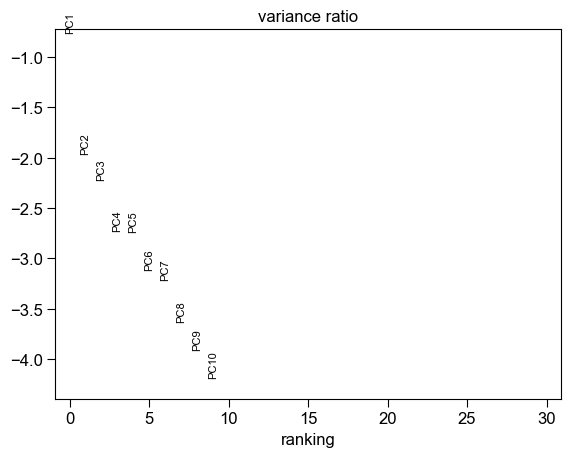

In [36]:
sc.pl.pca_variance_ratio(adata_l, log=True)

In [37]:
sc.pp.neighbors(adata_l, n_neighbors=10, n_pcs=8)
sc.tl.umap(adata_l)
sc.tl.leiden(adata_l,key_added='Unsupervised clusters',resolution=0.1)

In [ ]:
sc.tl.rank_genes_groups(adata_l, groupby='clusters', method='wilcoxon')
sc.tl.dendrogram(adata_l, groupby='clusters')
sc.pl.rank_genes_groups_heatmap(adata_l, n_genes=3,  swap_axes=True, vmin=-3, vmax=3, cmap='bwr',figsize=(10,7), show=False, dendrogram=False)

In [ ]:
sc.tl.rank_genes_groups(adata_l, groupby='cell_type', method='wilcoxon')
sc.tl.dendrogram(adata_l, groupby='cell_type')
sc.pl.rank_genes_groups_heatmap(adata_l, n_genes=3,  swap_axes=True, vmin=-3, vmax=3, cmap='bwr',figsize=(10,7), show=False, dendrogram=True)

/Users/junjie/anaconda3/envs/scanpy_Prox-seq/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1217: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/Users/junjie/anaconda3/envs/scanpy_Prox-seq/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/Users/junjie/anaconda3/envs/scanpy_Prox-seq/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1217: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_

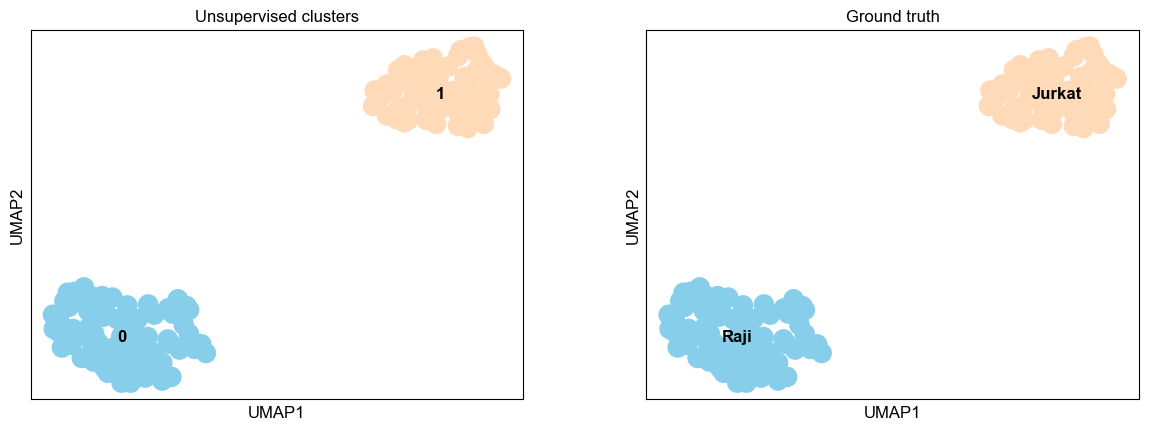

In [40]:
# Define custom color palettes
cluster_colors = {
    '0': 'skyblue',    # Example colors for clusters
    '1': 'peachpuff'
}

cell_type_colors = {
    'Raji': 'skyblue',
    'Jurkat': 'peachpuff'
}

adata_l.obs['Unsupervised clusters'] = adata_l.obs['Unsupervised clusters'].astype('category')
adata_l.obs['Ground truth'] = adata_l.obs['Ground truth'].astype('category')

# Assign custom color palettes to adata_p
adata_l.uns['Unsupervised clusters_colors'] = [cluster_colors[label] for label in adata_l.obs['Unsupervised clusters'].cat.categories]
adata_l.uns['Ground truth_colors'] = [cell_type_colors[label] for label in adata_l.obs['Ground truth'].cat.categories]

sc.pl.umap(adata_l,color=['Unsupervised clusters','Ground truth'], legend_loc='on data')

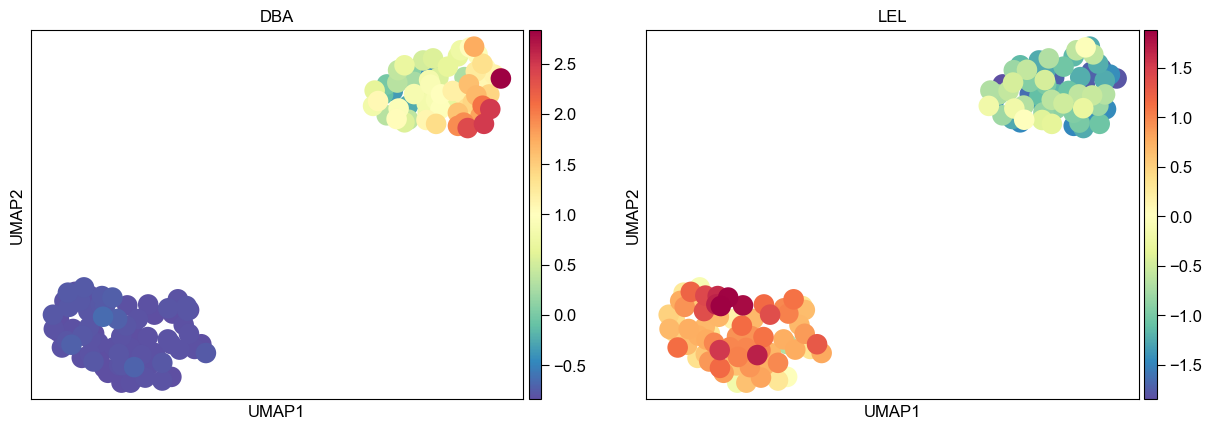

In [41]:
sc.pl.umap(adata_l,color=['DBA','LEL'], cmap='Spectral_r', ncols=2)

In [37]:
from sklearn.metrics import silhouette_score
silhouette_avg = silhouette_score(adata_l.X, adata_l.obs['clusters'])
print(silhouette_avg)

0.3934354285513487


In [73]:
ari_score = adjusted_rand_score(adata_l.obs['cell_type'], adata_l.obs['clusters'])
print(f'Adjusted Rand Index (ARI): {ari_score}')

nmi_score = normalized_mutual_info_score(adata_l.obs['cell_type'], adata_l.obs['clusters'])
print(f'Normalized Mutual Information (NMI): {nmi_score}')

Adjusted Rand Index (ARI): 1.0
Normalized Mutual Information (NMI): 1.0


In [ ]:
#lectin, after CLR normalization
temp1 = pd.DataFrame(0, index=clr_lectin_T.columns, columns=clr_lectin_T.index)
for i in temp1.columns:
    temp1.loc[:,i] = clr_lectin_T.loc[i,:] 

temp1.loc[:,"type"] = "Jurkat"
temp2 = pd.DataFrame(0, index=clr_lectin_B.columns, columns=clr_lectin_B.index)
for i in temp2.columns:
    temp2.loc[:,i] = clr_lectin_B.loc[i,:]
temp2.loc[:,"type"] = "Raji"
temp = pd.concat((temp1, temp2), axis=0)

# Violint plot      
fig, ax = plt.subplots(nrows=4, ncols=3, figsize=(9,12))
np.random.seed(1)
for counter, val in enumerate(my_lectin):
    row = counter // 3
    col = counter % 3
    sns.violinplot(y=val, x="type", data=temp, ax=ax[row,col],
                   cut=0, saturation=100, inner=None)
    sns.stripplot(y=val, x="type", data=temp, ax=ax[row,col],
                  jitter=0.25, color='k', size=3)
    ax[row,col].set_title(val)
    ax[row,col].set_xlabel("Cell type")    
    if col == 0:
        ax[row,col].set_ylabel("CLR Normalization Count")
    else:
        ax[row,col].set_ylabel("")
ax[-1, -1].axis('off')
fig.tight_layout(w_pad=1.3, h_pad=1.3)
sns.despine(fig=fig)

In [ ]:
#use kde plot instead
#kde plot for lectin
temp1 = pd.DataFrame(0, index=clr_lectin_T.columns, columns=clr_lectin_T.index)
for i in temp1.columns:
    temp1.loc[:,i] = clr_lectin_T.loc[i,:]
temp1.loc[:,"type"] = "Jurkat"

temp2 = pd.DataFrame(0, index=clr_lectin_B.columns, columns=clr_lectin_B.index)
for i in temp2.columns:
    temp2.loc[:,i] = clr_lectin_B.loc[i,:]
temp2.loc[:,"type"] = "Raji"

# Combine data
temp = pd.concat((temp1, temp2), axis=0)
#temp.replace(0, 10, inplace=True) 

# Define consistent tick values for x and y axes
#x_ticks = [1, 10, 100, 1000, 10000, 100000]  # Assuming log scale, adjust these values as needed
#y_ticks = [0, 0.5, 1.0, 1.5, 2.0, 2.5, 3.0] 

# Creating KDE plot with stripplot overlay
fig, ax = plt.subplots(nrows=4, ncols=3, figsize=(9, 12)) 
np.random.seed(1)

for counter, val in enumerate(my_lectin):
    row = counter // 3
    col = counter % 3
    sns.kdeplot(x=val, data=temp[temp['type']=='Raji'], fill=True, label='Raji', ax=ax[row,col])
    sns.kdeplot(x=val, data=temp[temp['type']=='Jurkat'], fill=True, label='Jurkat', ax=ax[row,col])
    ax[row, col].set_title(val)
    ax[row, col].set_xlabel('CLR Normalized Count')
    #ax[row, col].set_xticks(x_ticks)
    #ax[row, col].set_yticks(y_ticks)
    ax[row, col].legend(loc='upper left', bbox_to_anchor=(0.9,0.9),frameon=False, prop={'size': 6})
# Hide empty subplots
ax[-1, -1].axis('off')

fig.tight_layout(w_pad=1.3, h_pad=1.3)  # Adjust layout spacing
sns.despine(fig=fig)

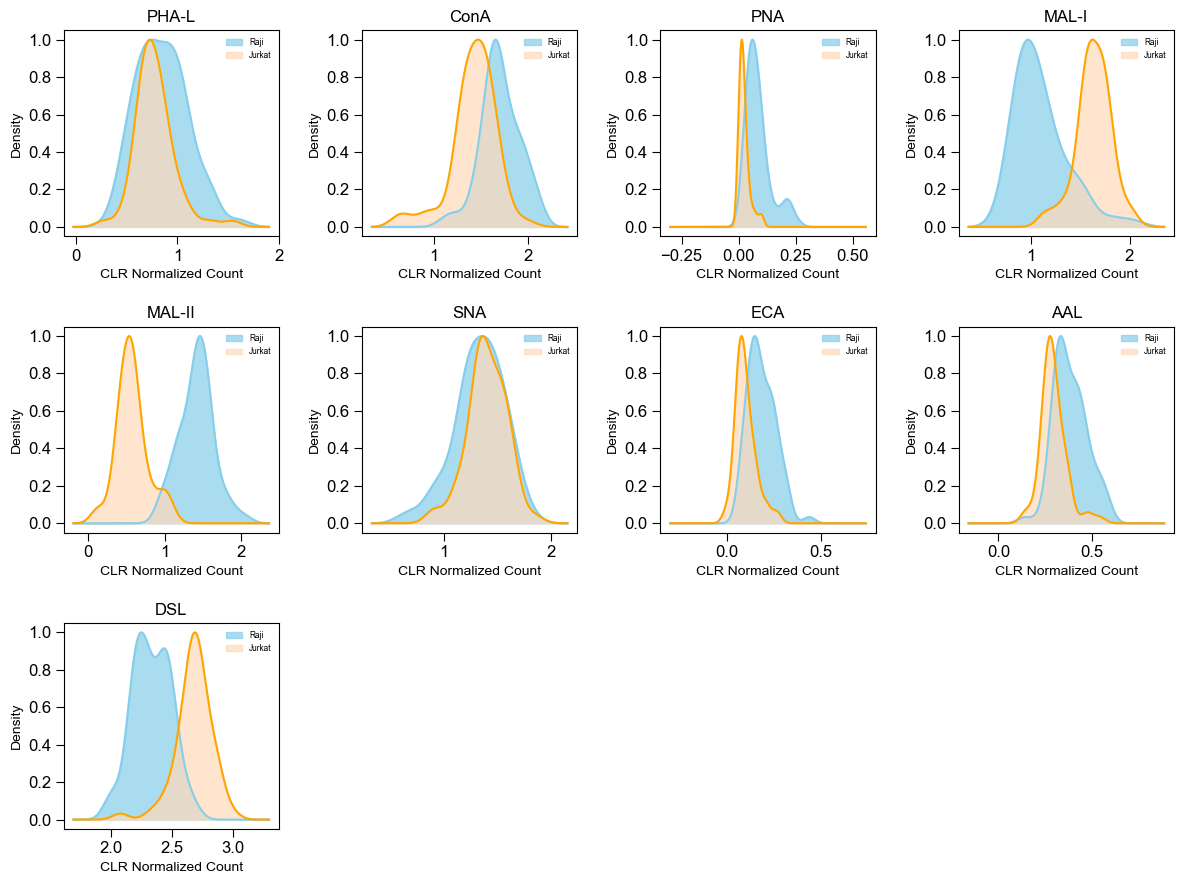

In [30]:
from scipy.stats import gaussian_kde

# Create KDE plots in 3 rows × 4 columns layout
fig, ax = plt.subplots(nrows=3, ncols=4, figsize=(12, 9))
np.random.seed(1)

excluded = ["DBA", "LEL"]
plot_lectins = [l for l in my_lectin if l not in excluded]

for counter, val in enumerate(plot_lectins):
    row = counter // 4
    col = counter % 4
    
    # Extract data for KDE computation
    data_raji = temp[temp['type'] == 'Raji'][val].dropna()
    data_jurkat = temp[temp['type'] == 'Jurkat'][val].dropna()
    
    # Compute KDE
    x_vals = np.linspace(min(data_raji.min()-0.3, data_jurkat.min()-0.3), 
                         max(data_raji.max()+0.3, data_jurkat.max()+0.3), 1000)
    
    kde_raji = gaussian_kde(data_raji)(x_vals)
    kde_jurkat = gaussian_kde(data_jurkat)(x_vals)
    
    # Normalize to max density
    kde_raji /= kde_raji.max()
    kde_jurkat /= kde_jurkat.max()
    
    # Plot normalized KDE
    ax[row, col].fill_between(x_vals, kde_raji, color='skyblue', alpha=0.7, label='Raji')
    ax[row, col].fill_between(x_vals, kde_jurkat, color='peachpuff', alpha=0.7, label='Jurkat')
    
    # Add line edges
    ax[row, col].plot(x_vals, kde_raji, color='skyblue', lw=1.5)
    ax[row, col].plot(x_vals, kde_jurkat, color='orange', lw=1.5)
    
    # Titles and labels
    ax[row, col].set_title(val, fontsize=12)
    ax[row, col].set_xlabel('CLR Normalized Count', fontsize=10)
    ax[row, col].set_ylabel('Density', fontsize=10)
    ax[row, col].legend(loc='upper right', frameon=False, prop={'size': 6})

# Hide unused subplots
for i in range(len(plot_lectins), ax.size):
    ax.flatten()[i].axis('off')

fig.tight_layout(w_pad=1.5, h_pad=1.5)
fig.savefig(save_dir + "SI_jr_lectin.svg", bbox_inches='tight', pad_inches=0)


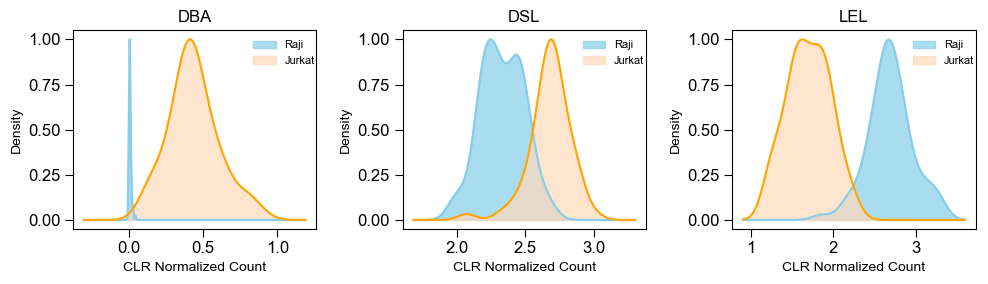

In [20]:
# Filter the lectins to only include 'DBA', 'DSL', 'LEL'
my_lectin_3 = ['DBA', 'DSL', 'LEL']

# Create KDE plots for the selected lectins
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(10, 3))  # Adjusted layout for 3 plots
np.random.seed(1)

for counter, val in enumerate(my_lectin_3):
    row = counter // 3
    col = counter % 3
    
    # Extract data for KDE computation
    data_raji = temp[temp['type'] == 'Raji'][val].dropna()
    data_jurkat = temp[temp['type'] == 'Jurkat'][val].dropna()
    
    # Compute KDE
    x_vals = np.linspace(min(data_raji.min() - 0.3, data_jurkat.min() - 0.3), 
                         max(data_raji.max() + 0.3, data_jurkat.max() + 0.3), 1000)
    
    kde_raji = gaussian_kde(data_raji)(x_vals)
    kde_jurkat = gaussian_kde(data_jurkat)(x_vals)
    
    # Normalize to max density
    kde_raji /= kde_raji.max()
    kde_jurkat /= kde_jurkat.max()
    
    # Plot normalized KDE with fill and edge
    ax[col].fill_between(x_vals, kde_raji, color='skyblue', alpha=0.7, label='Raji')
    ax[col].fill_between(x_vals, kde_jurkat, color='peachpuff', alpha=0.7, label='Jurkat')
    
    # Add line edges
    ax[col].plot(x_vals, kde_raji, color='skyblue', lw=1.5)
    ax[col].plot(x_vals, kde_jurkat, color='orange', lw=1.5)
    
    # Titles and labels
    ax[col].set_title(val, fontsize=12)
    ax[col].set_xlabel('CLR Normalized Count', fontsize=10)
    ax[col].set_ylabel('Density', fontsize=10)
    ax[col].legend(loc='upper left', bbox_to_anchor=(0.7, 1), frameon=False, prop={'size': 8})

# Adjust layout
fig.tight_layout(w_pad=1.5, h_pad=1.5)  # Adjust layout spacing
fig.savefig(save_dir+"Fig2_lectin_histogram.svg",
            bbox_inches='tight', pad_inches=0)
#sns.despine(fig=fig)  # Remove unnecessary spines

protein_lectin

In [42]:
#protein_lectin
#clr normalization 
import scanpy as sc
clr_pla_T = pla_jurkat.pla_count.apply(clr_function,axis=0)
clr_pla_B = pla_raji.pla_count.apply(clr_function,axis=0)

adata_T = sc.AnnData(X=clr_pla_T.transpose())
adata_B = sc.AnnData(X=clr_pla_B.transpose())
adata_T.obs['Ground truth'] = 'Jurkat'
adata_B.obs['Ground truth'] = 'Raji'

adata_pp = sc.concat([adata_T, adata_B])
adata_pp.raw = adata_pp # freeze the state in `.raw`
sc.pp.scale(adata_pp, max_value=10)
sc.tl.pca(adata_pp, svd_solver='arpack')

In [43]:
#Check the CD147 and CD81 specific lectin binding composition
temp_T = pla_jurkat.pla_count.copy()
temp_T.index = temp_T.index.to_series().str.replace('free_oligo', 'Other', regex=False)
temp_B = pla_raji.pla_count.copy()
temp_B.index = temp_B.index.to_series().str.replace('free_oligo', 'Other', regex=False)

pivot_t = pd.DataFrame({'mean':(temp_T).mean(axis=1)})
pivot_t['Protein'] = [s.split(':')[0] for s in temp_T.index]
pivot_t['Lectin'] = [s.split(':')[1] for s in temp_T.index]
pivot_t = pivot_t.pivot(index='Protein', columns='Lectin', values='mean')

pivot_b = pd.DataFrame({'mean':(temp_B).mean(axis=1)})
pivot_b['Protein'] = [s.split(':')[0] for s in temp_B.index]
pivot_b['Lectin'] = [s.split(':')[1] for s in temp_B.index]
pivot_b = pivot_b.pivot(index='Protein', columns='Lectin', values='mean')

#drop Other in protein and normalized data by row
pivot_t = pivot_t.drop(index='Other')
pivot_b = pivot_b.drop(index='Other')

pivot_t_norm = pivot_t.div(pivot_t.sum(axis=1), axis=0)
pivot_b_norm = pivot_b.div(pivot_b.sum(axis=1), axis=0)

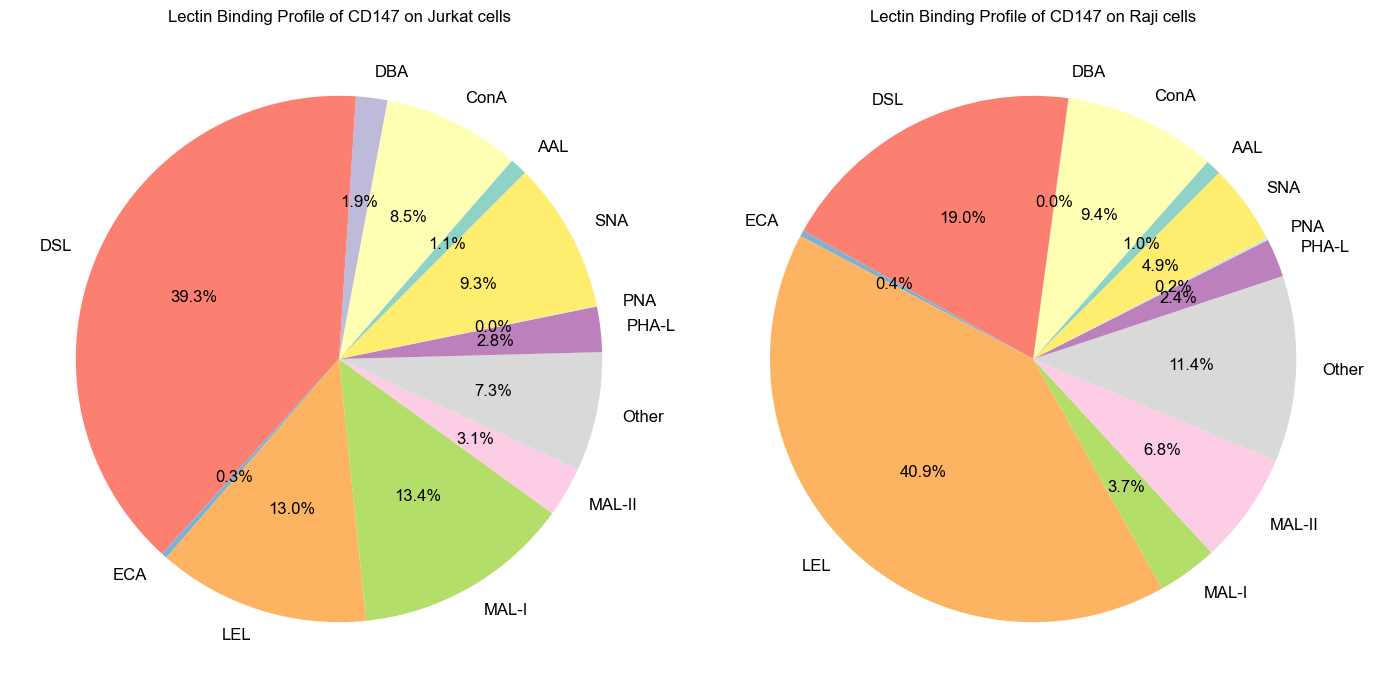

In [23]:
# Creating pie charts for CD147 and CD81
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 7))

# Pie chart for CD147
ax1.pie(pivot_t_norm.loc['CD147',:], labels=list(pivot_t_norm.columns), autopct='%1.1f%%', startangle=45, colors = sns.color_palette('Set3', len(list(pivot_t_norm.columns))))
ax1.set_title('Lectin Binding Profile of CD147 on Jurkat cells')

# Pie chart for CD81
ax2.pie(pivot_b_norm.loc['CD147',:], labels=list(pivot_t_norm.columns), autopct='%1.1f%%', startangle=45, colors = sns.color_palette('Set3', len(list(pivot_t_norm.columns))))
ax2.set_title('Lectin Binding Profile of CD147 on Raji cells')

# Display the pie charts
fig.tight_layout()
fig.savefig(save_dir+"Fig2_CD147_glycome.svg",
            bbox_inches='tight', pad_inches=0)

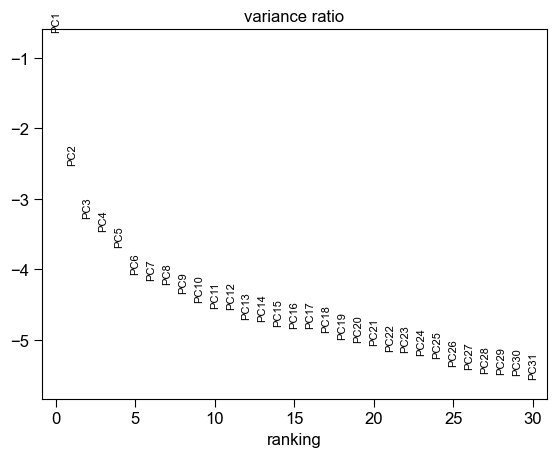

In [24]:
sc.pl.pca_variance_ratio(adata_pp, log=True)

In [44]:
sc.pp.neighbors(adata_pp, n_neighbors=10, n_pcs=10)
sc.tl.umap(adata_pp)
sc.tl.leiden(adata_pp,key_added='Unsupervised clusters',resolution=0.1)

/Users/junjie/anaconda3/envs/scanpy_Prox-seq/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1217: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/Users/junjie/anaconda3/envs/scanpy_Prox-seq/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/Users/junjie/anaconda3/envs/scanpy_Prox-seq/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1217: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_

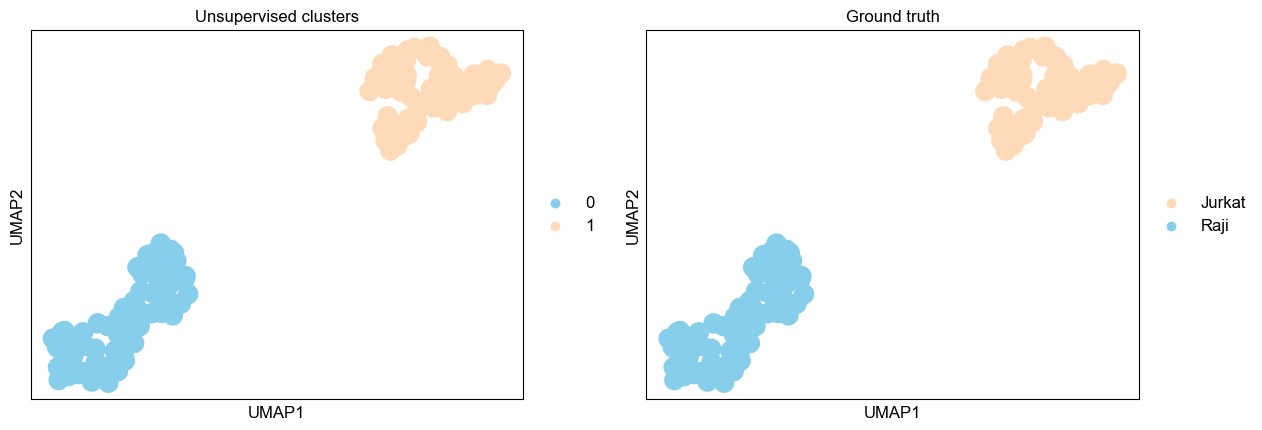

In [45]:
# Define custom color palettes
cluster_colors = {
    '0': 'skyblue',    # Example colors for clusters
    '1': 'peachpuff'
}

cell_type_colors = {
    'Raji': 'skyblue',
    'Jurkat': 'peachpuff'
}

adata_pp.obs['Unsupervised clusters'] = adata_pp.obs['Unsupervised clusters'].astype('category')
adata_pp.obs['Ground truth'] = adata_pp.obs['Ground truth'].astype('category')

# Assign custom color palettes to adata_p
adata_pp.uns['Unsupervised clusters_colors'] = [cluster_colors[label] for label in adata_pp.obs['Unsupervised clusters'].cat.categories]
adata_pp.uns['Ground truth_colors'] = [cell_type_colors[label] for label in adata_pp.obs['Ground truth'].cat.categories]

sc.pl.umap(adata_pp,color=['Unsupervised clusters','Ground truth'])

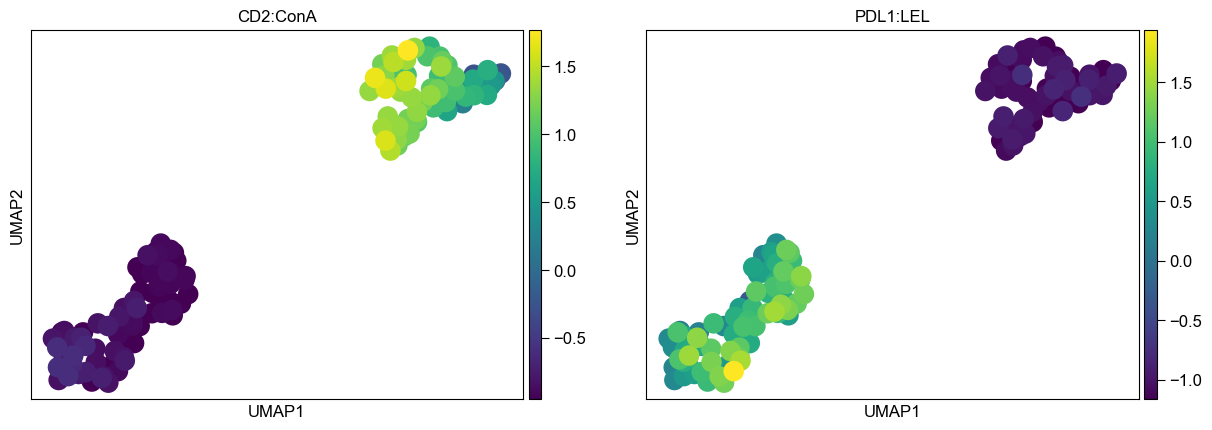

In [46]:
sc.pl.umap(adata_pp,color=['CD2:ConA','PDL1:LEL'], cma)

/Users/junjie/anaconda3/envs/scanpy_Prox-seq/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/Users/junjie/anaconda3/envs/scanpy_Prox-seq/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/Users/junjie/anaconda3/envs/scanpy_Prox-seq/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/Users/junjie/anaconda3/envs/scanpy_Prox-seq/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/Users/junjie/anaconda3/envs/scanpy_Prox-seq/lib/python3.10/site-packages/scanpy/plotting/_tools/sca

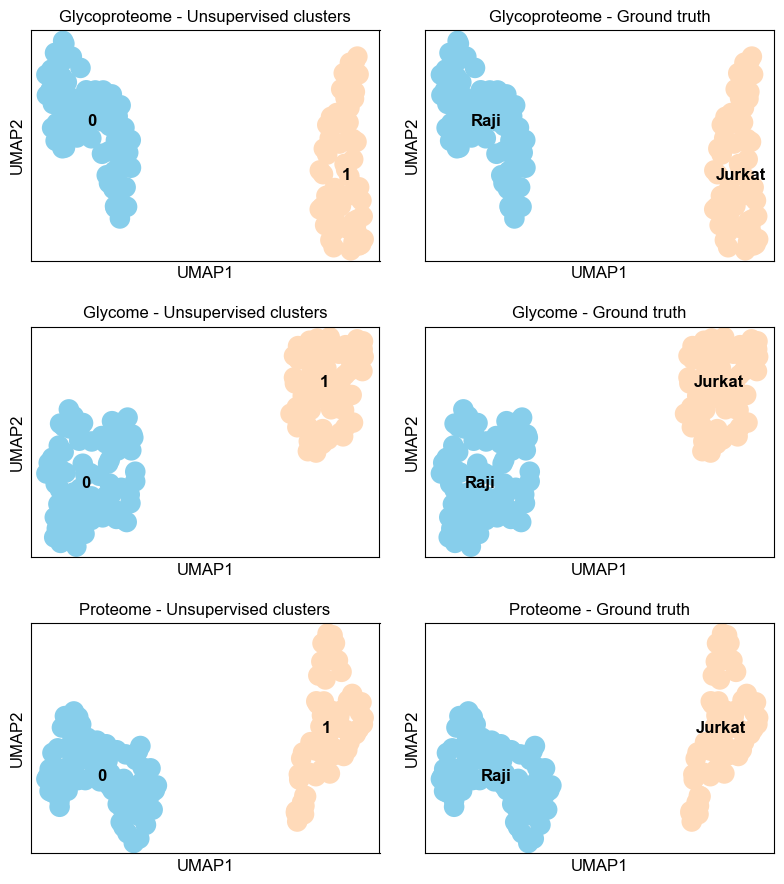

In [41]:
import matplotlib.pyplot as plt
import scanpy as sc

# Define the list of colors to plot
color_options = ['Unsupervised clusters', 'Ground truth']

# Create a figure for multiple UMAPs
fig, axs = plt.subplots(3, len(color_options), figsize=(8, 9))  # 3 rows, one for each dataset

# Plot for adata_pp
for i, color in enumerate(color_options):
    sc.pl.umap(
        adata_pp,
        color=color,
        ax=axs[0, i],
        legend_loc='on data',  # Place legend on data
        #size=15,
        show=False  # Prevent immediate display
    )
    axs[0, i].set_title(f"Glycoproteome - {color}")

# Plot for adata_l
for i, color in enumerate(color_options):
    sc.pl.umap(
        adata_l,
        color=color,
        ax=axs[1, i],
        legend_loc='on data',  # Place legend on data
        #size=15,
        show=False
    )
    axs[1, i].set_title(f"Glycome - {color}")

# Plot for adata_p
for i, color in enumerate(color_options):
    sc.pl.umap(
        adata_p,
        color=color,
        ax=axs[2, i],
        legend_loc='on data',  # Place legend on data
        #size=15,
        show=False
    )
    axs[2, i].set_title(f"Proteome - {color}")

fig.tight_layout(w_pad=1.5, h_pad=1.5)  # Adjust layout spacing
fig.savefig(save_dir+"Fig2_umap.svg",
            bbox_inches='tight', pad_inches=0)

/Users/junjie/anaconda3/envs/scanpy_Prox-seq/lib/python3.10/site-packages/scanpy/tools/_rank_genes_groups.py:420: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'logfoldchanges'] = np.log2(
/Users/junjie/anaconda3/envs/scanpy_Prox-seq/lib/python3.10/site-packages/scanpy/tools/_rank_genes_groups.py:420: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'logfoldchanges'] = np.log2(


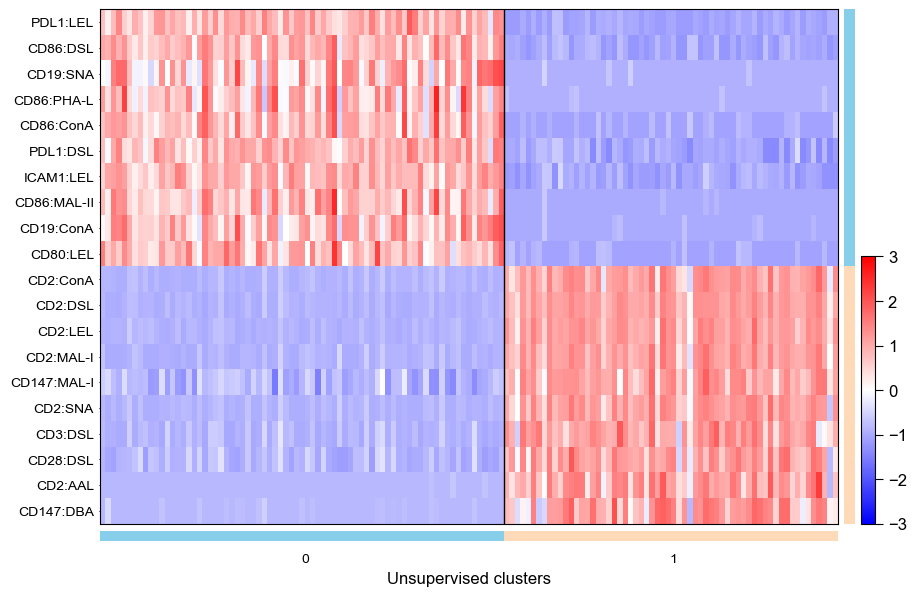

In [27]:
sc.tl.rank_genes_groups(adata_pp, groupby='Unsupervised clusters', method='wilcoxon')
sc.tl.dendrogram(adata_pp, groupby='Unsupervised clusters')
sc.pl.rank_genes_groups_heatmap(adata_pp, n_genes=10,  swap_axes=True, vmin=-3, vmax=3, cmap='bwr',figsize=(10,7), show_gene_labels=True, show=False, dendrogram=False)

/Users/junjie/anaconda3/envs/scanpy_Prox-seq/lib/python3.10/site-packages/scanpy/tools/_rank_genes_groups.py:420: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'logfoldchanges'] = np.log2(
/Users/junjie/anaconda3/envs/scanpy_Prox-seq/lib/python3.10/site-packages/scanpy/tools/_rank_genes_groups.py:420: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'logfoldchanges'] = np.log2(


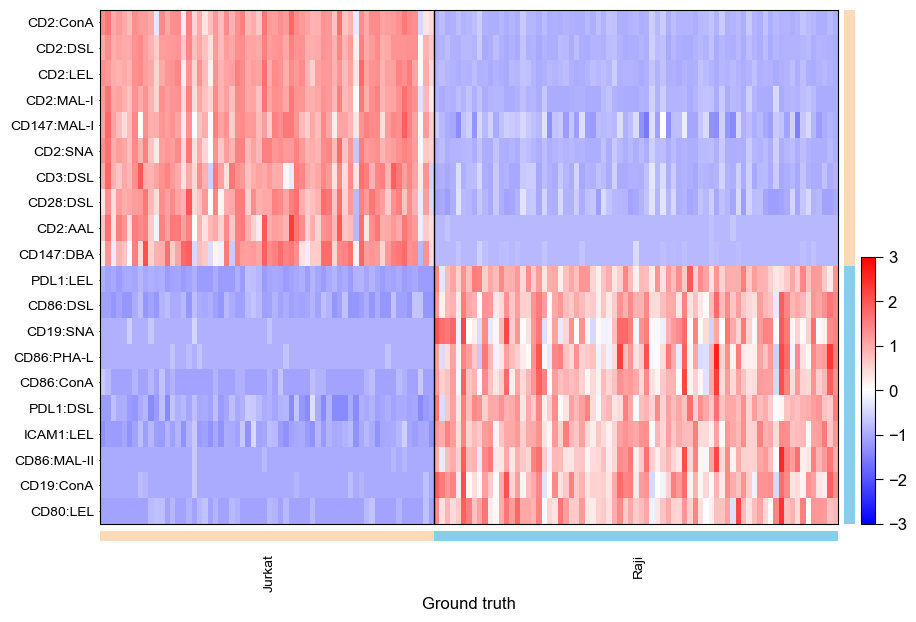

In [44]:
sc.tl.rank_genes_groups(adata_pp, groupby='Ground truth', method='wilcoxon')
sc.tl.dendrogram(adata_pp, groupby='Ground truth')
sc.pl.rank_genes_groups_heatmap(adata_pp, n_genes=10,  swap_axes=True, vmin=-3, vmax=3, cmap='bwr',figsize=(10,7), show=False, dendrogram=False)
plt.savefig(save_dir+"Fig2_heatmap_glycoproteome.svg",
            bbox_inches='tight', pad_inches=0)

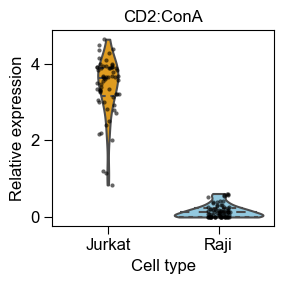

In [29]:
#violin plot for CD2:ConA and PDL1:LEL
# Extract the specific values for 'CD2:ConA' in each dataset
values_T = clr_pla_T.loc['CD2:ConA', :]
values_B = clr_pla_B.loc['CD2:ConA', :]

# Prepare the data for plotting
data_combined = pd.DataFrame({
    'Value': pd.concat([values_T, values_B]),
    'Group': ['Jurkat'] * len(values_T) + ['Raji'] * len(values_B)
})

# Custom colors (approximated from the image)
custom_palette = {'Jurkat': 'orange',  # Reddish-orange
                  'Raji': 'skyblue'}  # Teal-blue

# Create a violin plot with custom colors
plt.figure(figsize=(3, 3))
sns.violinplot(
    x='Group', 
    y='Value', 
    data=data_combined, 
    inner='quartile', 
    cut=0, 
    palette=custom_palette  # Apply custom colors
)
sns.stripplot(
    x='Group', 
    y='Value', 
    data=data_combined, 
    color='black', 
    alpha=0.6,
    size=3,
    jitter=True
)

# Customize the plot
plt.title('CD2:ConA')
plt.xlabel('Cell type')
plt.ylabel('Relative expression')

# Display the plot
plt.tight_layout()
plt.savefig(save_dir+"Fig2_violin_plot_CD2.svg",
            bbox_inches='tight', pad_inches=0)
#sns.despine()

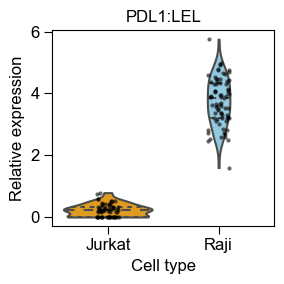

In [30]:
#violin plot for CD2:ConA and PDL1:LEL
# Extract the specific values for 'CD2:ConA' in each dataset
values_T = clr_pla_T.loc['PDL1:LEL', :]
values_B = clr_pla_B.loc['PDL1:LEL', :]

# Prepare the data for plotting
data_combined = pd.DataFrame({
    'Value': pd.concat([values_T, values_B]),
    'Group': ['Jurkat'] * len(values_T) + ['Raji'] * len(values_B)
})

# Custom colors (approximated from the image)
custom_palette = {'Jurkat': 'orange',  # Reddish-orange
                  'Raji': 'skyblue'}  # Teal-blue

# Create a violin plot with custom colors
plt.figure(figsize=(3, 3))
sns.violinplot(
    x='Group', 
    y='Value', 
    data=data_combined, 
    inner='quartile', 
    cut=0, 
    palette=custom_palette  # Apply custom colors
)
sns.stripplot(
    x='Group', 
    y='Value', 
    data=data_combined, 
    color='black', 
    alpha=0.6,
    size=3,
    jitter=True
)

# Customize the plot
plt.title('PDL1:LEL')
plt.xlabel('Cell type')
plt.ylabel('Relative expression')

# Display the plot
plt.tight_layout()
plt.savefig(save_dir+"Fig2_violin_plot_PDL1.svg",
            bbox_inches='tight', pad_inches=0)
#sns.despine()

In [33]:
from sklearn.metrics import silhouette_score
silhouette_avg = silhouette_score(adata_pp.X, adata_pp.obs['clusters'])
print(silhouette_avg)

0.4347126505036252


In [81]:
ari_score = adjusted_rand_score(adata_pp.obs['cell_type'], adata_pp.obs['clusters'])
print(f'Adjusted Rand Index (ARI): {ari_score}')

nmi_score = normalized_mutual_info_score(adata_pp.obs['cell_type'], adata_pp.obs['clusters'])
print(f'Normalized Mutual Information (NMI): {nmi_score}')

Adjusted Rand Index (ARI): 1.0
Normalized Mutual Information (NMI): 1.0
